# Data loading

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_train.csv
/kaggle/input/atis-airlinetravelinformationsystem/atis_intents.csv
/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_test.csv


## Installing requirements

In [6]:
import nltk
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
import string

In [7]:
# Problem with Kaggle infra when using wordnet. Have to unzip manually.
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

# EDA

In [2]:
df = pd.read_csv("/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_train.csv",names=["intent","query"],header=None)

In [3]:
df

,intent,query
0,atis_flight,i want to fly from boston at 838 am and arriv...
1,atis_flight,what flights are available from pittsburgh to...
2,atis_flight_time,what is the arrival time in san francisco for...
3,atis_airfare,cheapest airfare from tacoma to orlando
4,atis_airfare,round trip fares from pittsburgh to philadelp...
...,...,...
4829,atis_airfare,what is the airfare for flights from denver t...
4830,atis_flight,do you have any flights from denver to baltim...
4831,atis_airline,which airlines fly into and out of denver
4832,atis_flight,does continental fly from boston to san franc...


In [4]:
df["intent"].unique()

array(['atis_flight', 'atis_flight_time', 'atis_airfare', 'atis_aircraft',
       'atis_ground_service', 'atis_airline', 'atis_abbreviation',
       'atis_quantity'], dtype=object)

In [5]:
df_class_count = df.groupby(by='intent').count()

<AxesSubplot:ylabel='query'>

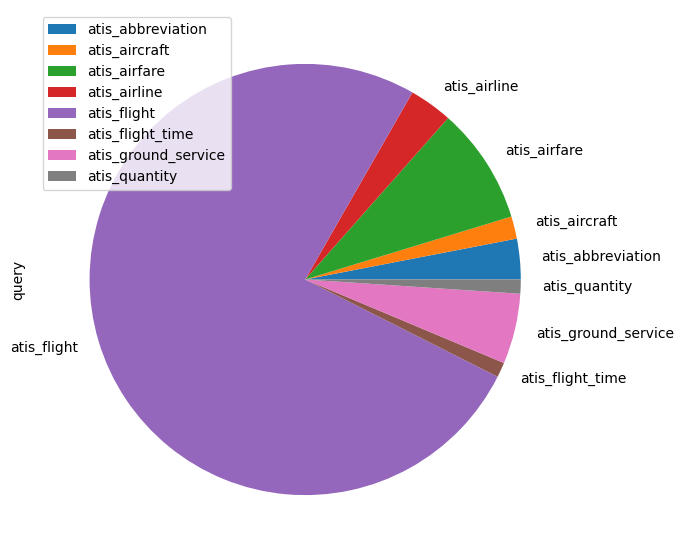

In [6]:
df_class_count.plot.pie(y="query", figsize=(10,7))

# First approach: ML models

## Text preprocessing

In [7]:
df_testing = df.copy()

In [8]:
import string

def remove_punctuation(text):
    punct_free = "".join([i for i in text if i not in string.punctuation])
    return punct_free

In [9]:
df_testing["punct_free"] = df_testing["query"].apply(lambda x: remove_punctuation(x))
df_testing.head()

,intent,query,punct_free
0,atis_flight,i want to fly from boston at 838 am and arriv...,i want to fly from boston at 838 am and arriv...
1,atis_flight,what flights are available from pittsburgh to...,what flights are available from pittsburgh to...
2,atis_flight_time,what is the arrival time in san francisco for...,what is the arrival time in san francisco for...
3,atis_airfare,cheapest airfare from tacoma to orlando,cheapest airfare from tacoma to orlando
4,atis_airfare,round trip fares from pittsburgh to philadelp...,round trip fares from pittsburgh to philadelp...


In [10]:
from nltk.tokenize import TreebankWordTokenizer

def tokenize(text):
    tokenizer = TreebankWordTokenizer()
    tokenized = tokenizer.tokenize(text)
    return tokenized

In [11]:
df_testing["tokenized"] = df_testing["punct_free"].apply(lambda x: tokenize(x))
df_testing.head()

,intent,query,punct_free,tokenized
0,atis_flight,i want to fly from boston at 838 am and arriv...,i want to fly from boston at 838 am and arriv...,"[i, want, to, fly, from, boston, at, 838, am, ..."
1,atis_flight,what flights are available from pittsburgh to...,what flights are available from pittsburgh to...,"[what, flights, are, available, from, pittsbur..."
2,atis_flight_time,what is the arrival time in san francisco for...,what is the arrival time in san francisco for...,"[what, is, the, arrival, time, in, san, franci..."
3,atis_airfare,cheapest airfare from tacoma to orlando,cheapest airfare from tacoma to orlando,"[cheapest, airfare, from, tacoma, to, orlando]"
4,atis_airfare,round trip fares from pittsburgh to philadelp...,round trip fares from pittsburgh to philadelp...,"[round, trip, fares, from, pittsburgh, to, phi..."


In [12]:
import nltk

def remove_stopwords(text):
    nltk_stop_words = nltk.corpus.stopwords.words("english")
    stop_words = nltk_stop_words + ["im","id"]
    output = [i for i in text if i not in stop_words]
    
    return output

In [13]:
df_testing["no_stopwords"] = df_testing["tokenized"].apply(lambda x: remove_stopwords(x))
df_testing.head()

,intent,query,punct_free,tokenized,no_stopwords
0,atis_flight,i want to fly from boston at 838 am and arriv...,i want to fly from boston at 838 am and arriv...,"[i, want, to, fly, from, boston, at, 838, am, ...","[want, fly, boston, 838, arrive, denver, 1110,..."
1,atis_flight,what flights are available from pittsburgh to...,what flights are available from pittsburgh to...,"[what, flights, are, available, from, pittsbur...","[flights, available, pittsburgh, baltimore, th..."
2,atis_flight_time,what is the arrival time in san francisco for...,what is the arrival time in san francisco for...,"[what, is, the, arrival, time, in, san, franci...","[arrival, time, san, francisco, 755, flight, l..."
3,atis_airfare,cheapest airfare from tacoma to orlando,cheapest airfare from tacoma to orlando,"[cheapest, airfare, from, tacoma, to, orlando]","[cheapest, airfare, tacoma, orlando]"
4,atis_airfare,round trip fares from pittsburgh to philadelp...,round trip fares from pittsburgh to philadelp...,"[round, trip, fares, from, pittsburgh, to, phi...","[round, trip, fares, pittsburgh, philadelphia,..."


In [14]:
from nltk.stem import WordNetLemmatizer

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lemm_text = [lemmatizer.lemmatize(word) for word in text]
    return " ".join(lemm_text)


In [23]:
# Problem with Kaggle infra when using wordnet. Have to unzip manually.
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [30]:
df_testing["lemmatized"] = df_testing["no_stopwords"].apply(lambda x:lemmatize(x))
df_testing.head()

,intent,query,punct_free,tokenized,no_stopwords,lemmatized
0,atis_flight,i want to fly from boston at 838 am and arriv...,i want to fly from boston at 838 am and arriv...,"[i, want, to, fly, from, boston, at, 838, am, ...","[want, fly, boston, 838, arrive, denver, 1110,...",want fly boston 838 arrive denver 1110 morning
1,atis_flight,what flights are available from pittsburgh to...,what flights are available from pittsburgh to...,"[what, flights, are, available, from, pittsbur...","[flights, available, pittsburgh, baltimore, th...",flight available pittsburgh baltimore thursday...
2,atis_flight_time,what is the arrival time in san francisco for...,what is the arrival time in san francisco for...,"[what, is, the, arrival, time, in, san, franci...","[arrival, time, san, francisco, 755, flight, l...",arrival time san francisco 755 flight leaving ...
3,atis_airfare,cheapest airfare from tacoma to orlando,cheapest airfare from tacoma to orlando,"[cheapest, airfare, from, tacoma, to, orlando]","[cheapest, airfare, tacoma, orlando]",cheapest airfare tacoma orlando
4,atis_airfare,round trip fares from pittsburgh to philadelp...,round trip fares from pittsburgh to philadelp...,"[round, trip, fares, from, pittsburgh, to, phi...","[round, trip, fares, pittsburgh, philadelphia,...",round trip fare pittsburgh philadelphia 1000 d...


In [3]:

import nltk
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
import string

def preprocess_atis(df):
    df["query"] = df["query"].apply(lambda x: _remove_punctuation(x))
    df["query"] = df["query"].apply(lambda x: _tokenize(x))
    df["query"] = df["query"].apply(lambda x: _remove_stopwords(x))
    df["query"] = df["query"].apply(lambda x: _lemmatize(x))
    
    return df


def _remove_punctuation(text):
    punct_free = "".join([i for i in text if i not in string.punctuation])
    return punct_free

def _tokenize(text):
    tokenizer = TreebankWordTokenizer()
    tokenized = tokenizer.tokenize(text)
    return tokenized

def _remove_stopwords(text):
    nltk_stop_words = nltk.corpus.stopwords.words("english")
    stop_words = nltk_stop_words + ["im","id"]
    output = [i for i in text if i not in stop_words]
    
    return output

def _lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lemm_text = [lemmatizer.lemmatize(word) for word in text]
    return " ".join(lemm_text)




## Data Split

In [4]:
intents = ['atis_flight', 'atis_flight_time', 'atis_airfare', 'atis_aircraft',
       'atis_ground_service', 'atis_airline', 'atis_abbreviation',
       'atis_quantity']
intent_dict = {intent:i+1 for i,intent in enumerate(intents)}

In [8]:
df_train = pd.read_csv("/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_train.csv",names=["intent","query"],header=None)
df_test = pd.read_csv("/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_test.csv",names=["intent","query"],header=None)

df_train_preprocessed = preprocess_atis(df_train)
df_test_preprocessed = preprocess_atis(df_test)

X_train = df_train_preprocessed["query"]
X_test = df_test_preprocessed["query"]

y_train = df_train_preprocessed["intent"].apply(lambda x: intent_dict[x])
y_test = df_test_preprocessed["intent"].apply(lambda x: intent_dict[x])

## TF-IDF vectorization

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

## Applying Naive Bayes classifier

In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

nb_clf = MultinomialNB()
nb_clf.fit(X_train_tfidf, y_train)

y_pred = nb_clf.predict(X_test_tfidf)

score1 = metrics.accuracy_score(y_test, y_pred)
print("accuracy:   %0.3f" % score1)

print(metrics.classification_report(y_test, y_pred,
                                            target_names=intents))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, y_pred))

print('------------------------------')

accuracy:   0.892
                     precision    recall  f1-score   support

        atis_flight       0.88      1.00      0.94       632
   atis_flight_time       0.00      0.00      0.00         1
       atis_airfare       0.92      0.23      0.37        48
      atis_aircraft       0.78      0.78      0.78         9
atis_ground_service       1.00      0.97      0.99        36
       atis_airline       0.80      0.11      0.19        38
  atis_abbreviation       1.00      0.79      0.88        33
      atis_quantity       0.00      0.00      0.00         3

           accuracy                           0.89       800
          macro avg       0.67      0.48      0.52       800
       weighted avg       0.89      0.89      0.86       800

confusion matrix:
[[631   0   1   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0]
 [ 37   0  11   0   0   0   0   0]
 [  2   0   0   7   0   0   0   0]
 [  1   0   0   0  35   0   0   0]
 [ 34   0   0   0   0   4   0   0]
 [  7   0   0   0  

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
y_test.value_counts()

1    632
3     48
6     38
5     36
7     33
4      9
8      3
2      1
Name: intent, dtype: int64

# Second approach: DL models